# Using Bayesian Methods to Predict Energy Efficiency

### Imports

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, linalg
import hmc_Lab as hmc

### Posterior and Error functions

In [111]:
def compute_posterior(X, y, alph, beta):
    Mu = np.array((np.linalg.inv((X.T@X) + ((1/beta)*alph*np.identity(9))) @ (X.T @ y)).ravel())
    SIGMA = np.array((1/beta) * np.linalg.inv((X.T@X) + ((1/beta)*alph*np.identity(9))))
    return Mu, SIGMA

def calc_RMSE(y, y_est):
    RMSE = np.sqrt(np.mean((y - y_est) ** 2))
    return RMSE

def calc_MAE(y, y_est):
    abs_err = np.abs(y_est-y)
    MAE = np.mean(abs_err)
    return MAE

### Data Processing

In [112]:
dat = pd.read_csv("ENB2012_data.csv")
train_dat = dat[:384]
test_dat = dat[384:]

X_train_dat = train_dat[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_train = np.array(train_dat['Y1'].tolist())

X_test_dat = test_dat[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_test = np.array(test_dat['Y1'].tolist())

X_train_norm_dat = (X_train_dat - X_train_dat.mean()) / X_train_dat.std()
X_train_norm_dat['const'] = 1
X_train = np.array(X_train_norm_dat)
print(X_train.shape)
print(y_train.shape)
X_test_norm_dat = (X_test_dat - X_train_dat.mean()) / X_train_dat.std()
X_test_norm_dat['const'] = 1
X_test = np.array(X_test_norm_dat)

(384, 9)
(384,)


### Using Type-2 maximum likelihood to estimate hyper-parameters

In [113]:
def compute_log_marginal(X, y, alph, beta):
    N, M = X.shape

    C = 1/beta * np.eye(N) + X @ X.T / alph

    lgp = -N/2 * np.log(2*np.pi)

    _, log_det = np.linalg.slogdet(C)

    lgp -= log_det / 2

    lgp -= y.T @ np.linalg.inv(C) @ y / 2
    return lgp

In [114]:
log_a_range = np.linspace(-5, 0, 100)
log_B_range = np.linspace(-5, 0, 100)
a_range = np.exp(log_a_range)
B_range = np.exp(log_B_range)

log_prob_y = np.zeros((len(log_a_range), len(log_B_range)))
for i, a_ in enumerate(a_range):
    for j, B_ in enumerate(B_range):
        log_prob_y[j, i]  = compute_log_marginal(X_train, y_train, a_, B_)

ind = np.unravel_index(np.argmax(log_prob_y), log_prob_y.shape)
mp_a = a_range[ind[1]]
mp_B = B_range[ind[0]]
mp_l_a = log_a_range[ind[1]]
mp_l_B = log_B_range[ind[0]]
print(f"Most probable Alpha: {mp_a}")
print(f"Most probable Beta: {mp_B}")
print(f"Most probable log Alpha: {mp_l_a}")
print(f"Most probable log Beta: {mp_l_B}")

Most probable Alpha: 0.014372706649902672
Most probable Beta: 0.11988622377030095
Most probable log Alpha: -4.242424242424242
Most probable log Beta: -2.121212121212121


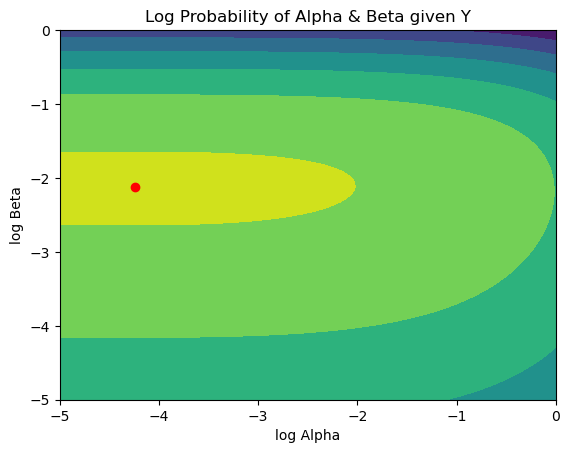

In [115]:
plt.contourf(log_a_range, log_B_range, log_prob_y)
plt.plot(mp_l_a,mp_l_B, 'ro')
plt.xlabel('log Alpha')
plt.ylabel('log Beta')
plt.title("Log Probability of Alpha & Beta given Y")

plt.show()

In [116]:
Mu, SIGMA = compute_posterior(X_train, y_train, mp_a, mp_B)
y_train_post = Mu @ X_train.T
y_test_post = Mu @ X_test.T
RMSE_train = calc_RMSE(y_train, y_train_post)
RMSE_test = calc_RMSE(y_test, y_test_post)
MAE_train = calc_MAE(y_train, y_train_post)
MAE_test = calc_MAE(y_test, y_test_post)
print(f"Weight values: {Mu}")
print(f"Training RMSE: {RMSE_train}")
print(f"Test RMSE: {RMSE_test}")
print(f"Training MAE: {MAE_train}")
print(f"Test MAE: {MAE_test}")

Weight values: [-6.69751815 -3.10299454  0.46246178 -3.24919897  7.94689312 -0.04313361
  2.22376818  0.77509564 20.2382128 ]
Training RMSE: 2.8307664611009185
Test RMSE: 4.0561986640826015
Training MAE: 2.019417727018286
Test MAE: 3.4091833723517095


### Applying Hamilton Monte Carlo method to find coefficients

In [117]:
def energy_func_lr(hps, x, y):
    w = hps[2:]
    alpha = hps[0]
    beta = hps[1]
    w_X = x@w
    N, M = x.shape
    likelihood = -N*np.log(2*np.pi)/2 + N*(beta)/2 - (np.exp(beta)/2 * np.sum((y-w_X)**2))
    prior = M*(alpha)/2 - (M*np.log((2*np.pi))/2) - ((np.exp(alpha)/2)*np.sum(w**2))
    neglgp = -(likelihood+prior)
    return neglgp

def energy_grad_lr(hps, x, y):
    
    w = hps[2:]
    alpha = hps[0]
    beta = hps[1]
    N, M = x.shape
    w_X = x@w

    dl_da = -(M/2 - (np.exp(alpha)*np.sum(w**2)/2))
    dl_dB = -(N/2 - (np.exp(beta)/2 * np.sum((y-w_X)**2)))
    d_dw = -(((y-w_X)@x)*np.exp(beta) - w*np.exp(alpha))
    
    a_b = [dl_da, dl_dB]
    g = np.array(a_b + list(d_dw))
   
    return g

In [118]:
np.random.seed(seed=1) 

R = 8500
L = 20
eps = 0.0085
# high acceptance rate because of high burn
burn = int(R/5)

hps = np.random.uniform(0,1, size=(11,1)).ravel()

S, *_ = hmc.sample(hps, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_train])

Calc.         Numeric       Delta         Acc.
    -3.81788      -3.81788  -6.269688e-06   6
      189410        189410  -3.006600e-06  11
    -4675.97      -4675.97  -1.559381e-05   9
     4962.29       4962.29  -6.007831e-06   9
     -3283.8       -3283.8  -4.579056e-06   9
     6424.66       6424.66   1.787440e-05   9
    -6674.23      -6674.23   6.333296e-06  10
     306.478       306.478  -1.726293e-05   8
    -1437.98      -1437.98  -3.887561e-06   9
    -185.349      -185.349  -9.147971e-06   8
    -15644.7      -15644.7  -2.726888e-05   9
|----------|  0% accepted [ 5 secs to go ]


/Users/george/AA . University Masters Work/Bayes/hmc_Lab.py:121: RuntimeWarning: overflow encountered in exp
  if np.random.uniform() < np.exp(current_U-proposed_U+current_K-proposed_K):


|#---------| 100% accepted [ 4 secs to go ]
|##--------| 100% accepted [ 4 secs to go ]
|###-------| 100% accepted [ 3 secs to go ]
|####------| 100% accepted [ 3 secs to go ]
|#####-----| 100% accepted [ 2 secs to go ]
|######----| 100% accepted [ 2 secs to go ]
|#######---| 100% accepted [ 1 secs to go ]
|########--| 100% accepted [ 1 secs to go ]
|#########-| 100% accepted [ 0 secs to go ]
|##########| 100% accepted [ 0 secs to go ]
HMC: R=8500 / L=20 / eps=0.0085 / Accept=99.9%


Weight values: [-4.52790579 -1.8039397   0.90392367 -2.19564794  8.12437383 -0.04291234
  2.21236054  0.7711195  20.1346623 ]
Log Alpha = -4.409193849770301
Log Beta = -2.1042501071023763
training RMSE: 2.846183953103809
test RMSE: 3.971034977449392
training MAE: 2.0254611262483677
test MAE: 3.3257646020642615


Text(0, 0.5, 'Log Alpha')

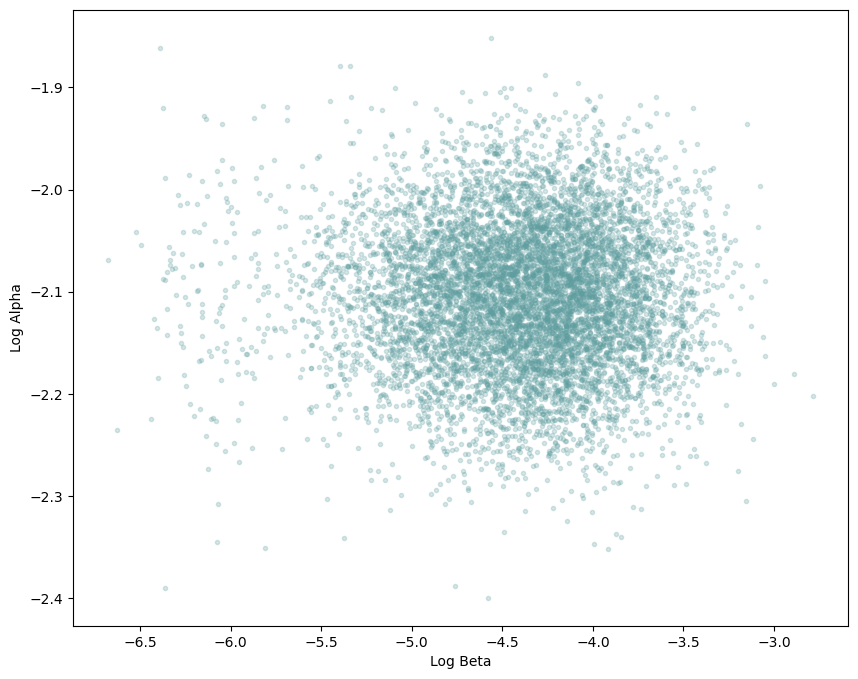

In [119]:
ham_a = np.mean(S[:,0])
ham_B = np.mean(S[:,1])
Mu, SIGMA = compute_posterior(X_train, y_train, ham_a, ham_B)
y_train_post = Mu @ X_train.T
y_test_post = Mu @ X_test.T
train_err = calc_RMSE(y_train, y_train_post)
test_err = calc_RMSE(y_test, y_test_post)
mae_train_err = calc_MAE(y_train, y_train_post)
mae_test_err = calc_MAE(y_test, y_test_post)
print(f"Weight values: {Mu}")
print(f"Log Alpha = {ham_a}")
print(f"Log Beta = {ham_B}")
print(f"training RMSE: {train_err}")
print(f"test RMSE: {test_err}")
print(f"training MAE: {mae_train_err}")
print(f"test MAE: {mae_test_err}")
fsz = (10,8)
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.xlabel("Log Beta")
plt.ylabel("Log Alpha")

### Using HMC as a classifier

In [120]:
y_log_train = np.array([1 if y>23 else 0 for y in y_train])
y_log_test = np.array([1 if y>23 else 0 for y in y_test])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def bernoulli_likelihood(X, y):
    p_success = sigmoid(X)
    pmf = np.sum(stats.bernoulli.logpmf(y, p_success))
    return pmf

def energy_func_logistic(hps, x, y):
    alpha = hps[0]
    w = hps[1:]
    M = len(w)
    w_X = x@w
    prior = M*(alpha)/2 - (M*np.log((2*np.pi))/2) - ((np.exp(alpha)/2)*np.sum(w**2))
    neglgp = -(bernoulli_likelihood(w_X, y)+prior)
    return neglgp

def energy_grad_logistic(hps, x, y):
    alpha = hps[0]
    w = hps[1:]
    M = len(w)
    s_w_x = sigmoid(x@w)
    dl_da = [-(M/2 - (np.exp(alpha)*np.sum(w**2)/2))]
    d_w = -((y-s_w_x)@x - np.exp(alpha)*w)
    g = np.array(dl_da + list(d_w))
    
    return g

R = 10000
L = 25
eps = 0.17
burn = int(R/10)
np.random.seed(seed=1)
hps = (np.random.uniform(0, 1, size=(10, 1)).ravel())
S, *_ = hmc.sample(hps, energy_func_logistic, energy_grad_logistic, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_log_train])

log_alpha = S[-1][0]
weights = S[-1][1:]
x_weights_train = X_train @ weights
x_weights_test = X_test @ weights

y_train_pred = np.array([1 if x_w>0 else 0 for x_w in x_weights_train])
y_test_pred = np.array([1 if x_w>0 else 0 for x_w in x_weights_test])

def logistic_error(y_pred, y_act):
    return 100*(np.sum(np.abs(y_pred-y_act))/len(y_pred))

train_error = logistic_error(y_train_pred, y_log_train)
test_error = logistic_error(y_test_pred, y_log_test)
print(f"Optimal weights: {weights}")
print(f"Classification train error: {train_error}%")
print(f"Classification test error: {test_error}%")

Calc.         Numeric       Delta         Acc.
    -3.55753      -3.55753   7.698602e-10  10
    -88.5752      -88.5752  -6.514071e-09  11
     95.0867       95.0867  -6.683806e-09  11
    -45.7499      -45.7499  -1.571216e-08  10
     115.262       115.262  -1.153585e-08  10
     -119.78       -119.78  -3.344242e-08  10
     16.2042       16.2042  -7.627968e-09  10
     2.17763       2.17763  -2.405880e-08   8
     12.2134       12.2134  -1.554721e-09  10
     65.5248       65.5248  -1.372391e-08  10
|----------|  0% accepted [ 8 secs to go ]
|#---------| 85% accepted [ 7 secs to go ]
|##--------| 85% accepted [ 6 secs to go ]
|###-------| 85% accepted [ 5 secs to go ]
|####------| 85% accepted [ 4 secs to go ]
|#####-----| 85% accepted [ 4 secs to go ]
|######----| 85% accepted [ 3 secs to go ]
|#######---| 85% accepted [ 2 secs to go ]
|########--| 85% accepted [ 2 secs to go ]
|#########-| 85% accepted [ 1 secs to go ]
|##########| 85% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 

### Using Variational Inference to find coefficients

In [121]:
def VI(X_train, Y_train):
    a0 = 0.0001
    b0 = 0.0001
    c0 = 0.0001
    d0 = 0.0001
    
    an = 0.0001
    bn = 0.0001
    cn = 0.0001
    dn = 0.0001
    mu_0 = 0
    beta_0 = 1

    N, M = X_train.shape
    an = a0 + M / 2
    cn = c0 + N / 2

    max_iter = 1000
    for _ in range(max_iter):
        s2 = 1/(cn/dn)
        e_alpha = an/bn
        sig_n = np.linalg.inv(((X_train.T@X_train)/(s2)) + (e_alpha*np.eye(M)))
        mu_n = (sig_n@(X_train.T@Y_train))/(s2)
        wTw = (mu_n.T@mu_n) + np.trace(sig_n)
        bn = b0 + 0.5 * (wTw)
        mu_B = (beta_0*mu_0 + N*np.mean(X_train))/(beta_0+N)
        dn = d0 + 0.5*np.sum((X_train-mu_B)**2 + beta_0*(mu_B-mu_0)**2)
    
    return an,bn,cn,dn, mu_n, sig_n

In [122]:
an,bn,cn,dn, mu_n, sig_n = VI(X_train, y_train)
exp_alpha = an/bn
exp_beta = cn/dn
print(f"Expectation Alpha: {exp_alpha}")
print(f"Expectation Beta: {exp_beta}")
print(f"Expectation log Alpha: {np.log(exp_alpha)}")
print(f"Expectation log Beta: {np.log(exp_beta)}")
print(f"Weights: {mu_n}")

Expectation Alpha: 0.014583812471013934
Expectation Beta: 0.11137610196169855
Expectation log Alpha: -4.227843100231101
Expectation log Beta: -2.1948424990834456
Weights: [-6.67445037 -3.08767253  0.46645101 -3.23618451  7.95225199 -0.04313236
  2.22370401  0.77507327 20.23763032]


In [123]:
y_train_post = mu_n @ X_train.T
y_test_post = mu_n @ X_test.T
train_err = calc_RMSE(y_train, y_train_post)
test_err = calc_RMSE(y_test, y_test_post)
mae_train_err = calc_MAE(y_train, y_train_post)
mae_test_err = calc_MAE(y_test, y_test_post)
print(f"training RMSE: {train_err}")
print(f"test RMSE: {test_err}")
print(f"training MAE: {mae_train_err}")
print(f"test MAE: {mae_test_err}")

training RMSE: 2.830790843455396
test RMSE: 4.055688354233558
training MAE: 2.0194079559741316
test MAE: 3.4085659291551345
